In [1]:
# Import the necessary packages
import os
import numpy as np
import numpy.matlib
import math
from itertools import *
import more_itertools
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pyfftw
import simplespectral
 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras



In [2]:
# parameters
user = "Parham"
fs = 16000;
filesN = 1132;
angleN = 8;
micN= 2;
windowIncrease = 0.1 #in sec
windowSize = 5 #in sec
filterOrder = 10
filterBand = [200,5000] #in Hertz
fftWindowN = 257 # singlesided
featureType = "magnitude"
speakerType = ["cmu_us_jmk_arctic"]#, "cmu_us_bdl_arctic", "cmu_us_clb_arctic", "cmu_us_jmk_arctic"] # , "cmu_us_ksp_arctic", "cmu_us_rms_arctic", "cmu_us_slt_arctic"
speakerTypeN = 1
if user == "Felix":
    folderPath = "./../../../../Shared/SoundLocalization/speech_database/" + str(math.ceil(fs/1000)) + "khz" + "/"
else:
    folderPath = "./../Polybox/SoundLocalization/speech_database/" + str(math.ceil(fs/1000)) + "khz"
#audioCh1Data = np.ndarray([0,windowSize*fs])
#audioCh2Data = np.ndarray([0,windowSize*fs])
readBatchOn = True;
filterOn = False;

In [3]:
# read in data

# init
audioCh1Data = []
audioCh2Data = []
Y = []
count = 0
folderN = len(speakerType)
if fs == 16000:
    if featureType == "raw":
        samplesN = 113599;
        data = np.zeros((samplesN, angleN, filesN, micN, speakerTypeN), dtype = np.int16)
    if featureType == "magnitude":
        samplesN = 113851;
        fftWindowT = int(samplesN / fftWindowN);
        data = np.zeros((speakerTypeN,filesN, angleN, fftWindowT, fftWindowN, micN), dtype = np.int16) # fftWindowN, fftWindowT, angleN, filesN, speakerTypeN, micN

# read data
for folder_i in range(speakerTypeN):
    if readBatchOn:

        # read data file
        print ("read data file")
        fs, data_i = wavfile.read(folderPath + "/" + speakerType[folder_i] + "_" + featureType + ".wav")
        print ("finish load data file")
        print (np.shape(data_i))
        
        # 
        if filterOn:
            sos = signal.butter(filterOrder, filterBand, 'bp', fs=fs, output='sos')
            data_i[:,0] = signal.sosfilt(sos, data_i[:,0])
            data_i[:,1] = signal.sosfilt(sos, data_i[:,1])
            
        # reshape into invidual databases
        if featureType == "raw":
            data_i = np.reshape(data_i, (samplesN, angleN, filesN, micN))
        if featureType == "magnitude":            
            data_i = np.reshape(data_i, (filesN, angleN, fftWindowT, fftWindowN, micN))
            print (np.shape(data_i))
            
        # merge into one database
        data[folder_i,:,:,:,:,:] = data_i
        
        print("data reshaped")
        print(np.shape(data))
        
    else:
        for i in os.listdir(folderPath + folder):           # iteration over all single data files
            
            # get meta data
            deg = int(i[i.rfind("_")+1:i.find("degree")])/180*math.pi # read angle
            dist = 1 # read distance
            number = int(i[i.rfind("arctic")+7:i.find(str(math.ceil(fs/1000)) + "k")-1]) # read file number
            
            # read data file
            tempData = data
            audioCh1 = data[:,0]
            audioCh2 = data[:,1]
            
            # filter
            if filterOn:
                sos = signal.butter(filterOrder, filterBand, 'bp', fs=fs, output='sos')
                audioCh1 = signal.sosfilt(sos, audioCh1)
                audioCh2 = signal.sosfilt(sos, audioCh2)
        
            # window (rectangular)
            tempData = list(more_itertools.windowed(audioCh1, n=int(windowSize*fs), step=int(windowIncrease*fs)))
            tempData.pop()
            audioCh1Data.extend(tempData)
        
            tempData = list(more_itertools.windowed(audioCh2, n=int(windowSize*fs), step=int(windowIncrease*fs)))
            tempData.pop()
            audioCh2Data.extend(tempData)
        
            # resphape into one array
            dataSize = (np.shape(tempData))[0]
            Y.extend(list(np.repeat([dist,deg],dataSize))) 
        
            # log
            print (i)
            
print ("finished all data files' load")

read data file
finish load data file
(1031034656, 2)
(1132, 8, 443, 257, 2)
data reshaped
(1, 1132, 8, 443, 257, 2)
finished all data files' load


(1, 1132, 8, 443, 257, 2)
(9056, 1)
(9056, 50, 257, 2)


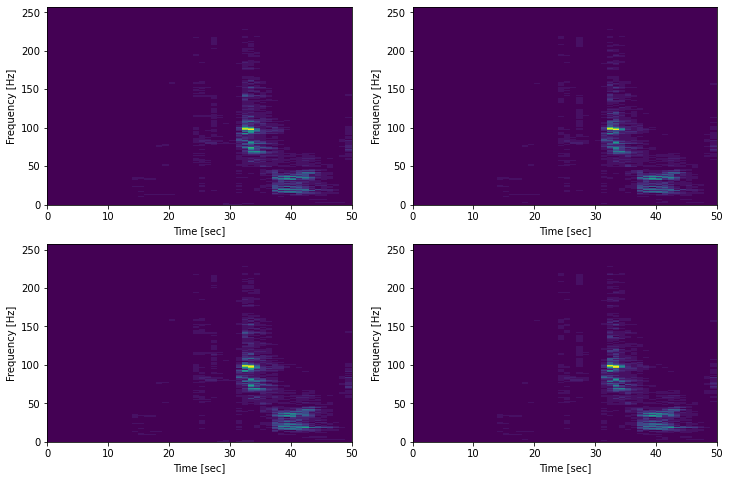

In [4]:
# calculate features
                        # speaker, file number, angle, time bins, frequency bins, channel

# clip dataset to just 1.4sec of data
fftWindowT_clipped = 50;
data_clipped = data[:,:,:,100:100+fftWindowT_clipped,:,:]
# show dimensions
print (np.shape(data)) 

# visualize features
plt.figure(figsize=(12, 8))
plt.subplot (221)
plot_data = data_clipped[0,1131,0,:,:,0]
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.subplot (222)
plot_data = data_clipped[0,1131,0,:,:,1]
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# prepare features for neural network
X = np.reshape(data_clipped, (angleN * filesN * speakerTypeN, fftWindowT_clipped, fftWindowN, micN))

plt.subplot (223)
plot_data = X[9048,:,:,0]
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.subplot (224)
plot_data = X[9048,:,:,1]
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(plot_data.transpose())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# get meta data
deg = np.linspace(0, 315, angleN)
deg = np.matlib.repmat(deg, 1, filesN  * speakerTypeN).transpose()
#dist = np.full((filesN * angleN * speakerTypeN, 1), 1)

# prepare lables for neural network
#Y = np.vstack((deg.T, dist.T)).T
Y = deg#/360
print (np.shape(Y)) # speaker-angle-file number, angle, distance
print (np.shape(X)) # speaker-angle-file number, time bins, frequency bins, channel


In [13]:
print (np.max(X))
print (np.min(X))

XFFTSmall = X[:,:,0:257:4,:]

X_train, X_validate, Y_train, Y_validate = train_test_split(XFFTSmall, Y, test_size = 0.2, random_state = 2)

Y_train = Y_train/45
Y_train = keras.utils.to_categorical (Y_train,8)
Y_validate = Y_validate/45
Y_validate = keras.utils.to_categorical (Y_validate,8)

print (np.shape(X_train))
print (np.shape(X_validate))
print (np.shape(Y_train))
print (np.shape(Y_validate))

# X_train = X_train.astype('float16')
# X_validate = X_validate.astype('float16')
# Y_train = Y_train.astype('float16')
# Y_validate = Y_validate.astype('float16')

92
0
(7244, 50, 65, 2)
(1812, 50, 65, 2)
(7244, 8)
(1812, 8)


In [15]:
# Define batchsize and number of epochs
batchSize = 50
nEpochs = 30

#keras.backend.set_floatx('float16')

# Declare the sequential model and design your multi-layer perceptron
model = keras.models.Sequential()

model.add (keras.layers.InputLayer(input_shape=X_train.shape[1:]))

model.add(keras.layers.Conv2D(4, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,4)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(4, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,4)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(4, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1,2)))
model.add(keras.layers.Dropout(0.2))

#model.add(Reshape((4,fftWindowT_clipped)))
#model.add(Bidirectional(GRU(4,activation='tanh',return_sequences=True),merge_mode='mul'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dense(16))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Activation('softmax'))

# Compile your model
# model.compile(loss='mean_absolute_error',
#               optimizer='sgd',
#               metrics=['mae','mse'])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train your model
model.fit(X_train, Y_train, epochs = nEpochs , batch_size = batchSize)


Epoch 1/30
145/145 [==============================] - 10s 67ms/step - loss: 2.2258 - accuracy: 0.1469
Epoch 2/30
145/145 [==============================] - 10s 66ms/step - loss: 1.9335 - accuracy: 0.2245
Epoch 3/30
145/145 [==============================] - 10s 67ms/step - loss: 1.7473 - accuracy: 0.3154
Epoch 4/30
145/145 [==============================] - 11s 75ms/step - loss: 1.4772 - accuracy: 0.4181
Epoch 5/30
145/145 [==============================] - 11s 74ms/step - loss: 1.1964 - accuracy: 0.5399
Epoch 6/30
145/145 [==============================] - 11s 74ms/step - loss: 1.0527 - accuracy: 0.5988
Epoch 7/30
145/145 [==============================] - 11s 74ms/step - loss: 0.9587 - accuracy: 0.6307
Epoch 8/30
145/145 [==============================] - 11s 74ms/step - loss: 0.9016 - accuracy: 0.6641
Epoch 9/30
145/145 [==============================] - 11s 74ms/step - loss: 0.8687 - accuracy: 0.6759
Epoch 10/30
145/145 [==============================] - 11s 75ms/step - loss: 0.837

In [16]:
model.build()
model.summary ()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 50, 65, 4)         76        
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 65, 4)         16        
_________________________________________________________________
activation_7 (Activation)    (None, 50, 65, 4)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 16, 4)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 16, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 16, 4)         148       
_________________________________________________________________
batch_normalization_7 (Batch (None, 50, 16, 4)        

In [17]:
model.evaluate (X_validate,Y_validate)

57/57 [==============================] - 1s 11ms/step - loss: 0.5160 - accuracy: 0.8129


[0.5160250067710876, 0.8129138946533203]

In [ ]:
Y_pred = model.predict (X_validate)
index = 0
plt.plot (Y_pred,'bs',Y_validate,'g^')
plt.show()

In [ ]:
model.evaluate (X_train,Y_train)

In [ ]:
Y_pred = model.predict (X_train)
index = 0
plt.plot (Y_pred,'bs',Y_train,'g^')
plt.show()

In [18]:
model.save ('classificationSmallTimeWithoutGRU.h5')

In [ ]:
model = models.load_model('classificationSmallTimeWithoutGRU.h5')

SyntaxError: invalid syntax (<ipython-input-12-cb235b7b1295>, line 1)